In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_logistic_ci, classical_logistic_ci
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

# Import the census income data set

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_healthcare")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

# Problem setup

In [3]:
alpha = 0.05
coordinate = 0 # Choose between 0, 1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(100, 2000, 3).astype(
    int
)  # Test for different numbers of labeled ballots
num_trials = 10
# Compute ground truth
true_theta = LogisticRegression(
    penalty="none",
    solver="lbfgs",
    max_iter=10000,
    tol=1e-15,
    fit_intercept=False,
).fit(X_total, Y_total).coef_.squeeze()[coordinate]

# Construct intervals

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in range(ns.shape[0]):
    for j in tqdm(range(num_trials)):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = Yhat_total[rand_idx[:n]], Yhat_total[rand_idx[n:]]
        
        ppi_ci = ppi_logistic_ci(_X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha, grid_relative=True, grid_radius=5, step_size=1e-10, grad_tol=1e-1)
        
        # Classical interval
        classical_ci = classical_logistic_ci(_X, _Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coordinate],
                        "upper": ppi_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0][coordinate],
                        "upper": classical_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_logistic_ci(X_total, (Yhat_total > 0.5).astype(int), alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0][coordinate],
                "upper": imputed_ci[1][coordinate],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.18s/it]


# Plot results

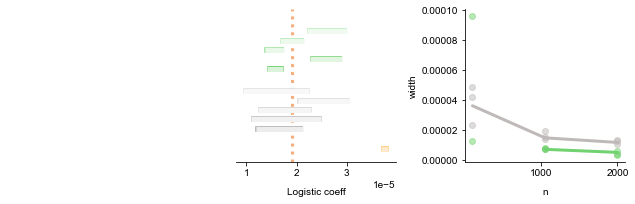

In [5]:
make_plots(
    df,
    "./plots/census_healthcare.pdf",
    intervals_xlabel="Logistic coeff",
    n_idx=-1,
    true_theta=true_theta,
)

In [7]:
# Find n such that we reject H0: Logistic coeff < 0.5*1e-5 with probability 80% using a test at level alpha
num_experiments = 10
list_rand_idx = [np.random.permutation(n_total) for i in range(num_experiments)]

def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = Yhat_total[rand_idx[:n]], Yhat_total[rand_idx[n:]]
        
        ppi_ci = ppi_logistic_ci(_X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha, grid_relative=True, grid_radius=5, step_size=1e-10, grad_tol=1e-1)
        if ppi_ci[0][coordinate] > 1.5e-5:
            nulls_rejected += 1
    return nulls_rejected/num_experiments - 0.8

def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = Yhat_total[rand_idx[:n]], Yhat_total[rand_idx[n:]]
        
        classical_ci = classical_logistic_ci(_X, _Y, alpha=alpha)
        if classical_ci[0][coordinate] > 1.5e-5:
            nulls_rejected += 1
    return nulls_rejected/num_experiments - 0.8

In [8]:
n_ppi = int(brentq(_to_invert_ppi, 100, 2000, xtol=100))
n_classical = int(brentq(_to_invert_classical, 100, 20000, xtol=100))
print(f"The PPI test requires n={n_ppi} labeled data points to reject the null.")
print(f"The classical test requires n={n_classical} labeled data points to reject the null.")

The PPI test requires n=2000 labeled data points to reject the null.
The classical test requires n=11708 labeled data points to reject the null.
